In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tqdm
from tqdm.keras import TqdmCallback

from src.ml.ml_reg import MLP_Model
from src.ml.ml_reg import LSTM_Model
import src

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "figure.dpi": 100,
})
%matplotlib inline

In [3]:
exps = ['Test 11',
        'Test 14',
        'Test 15',
        'Test 16',
        'Test 17',
        'Test 18',
        'Test 19',
        ]
exps = [src.load(exp) for exp in exps]
dfs = [exp.features.iloc[1:] for exp in exps]

In [24]:
main_df = pd.concat(dfs)
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Radius diff',
                                # 'Mean radius',
                                'Avg probe',
                                'Probe diff',
                                ])#.drop([0, 1, 2, 3])
main_df.reset_index(drop=True, inplace=True)
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 960 rows x 8 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius
0,0.039208,15.358375,1.581795,0.019882,29.507773,36.712393,16.873432,0.672499
1,0.289873,11.720536,8.527955,0.061386,31.941039,52.078281,39.609882,0.671830
2,0.720448,6.666400,7.369736,-0.095615,36.136609,61.848164,47.254065,0.669854
3,0.949587,5.552429,9.247926,-0.085875,35.081427,66.172557,48.616375,0.668865
4,0.974782,5.480675,8.517215,-0.073499,34.281257,66.067365,48.321941,0.668145


In [51]:
def pred_plot(y: np.ndarray,
              y_pred: np.ndarray,
              title: str = '',
              ):
    assert y.shape == y_pred.shape, 'y and y_pred must have the same shape'

    if y.ndim == 1:
        y = y.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    n_outputs = y.shape[1]

    fig, ax = plt.subplots(n_outputs, 2, figsize=(12, 6 * n_outputs))
    ax = ax.reshape(n_outputs, 2)

    for i in range(n_outputs):
        ax[i, 0].scatter(y[:, i], y_pred[:, i])
        lims = [
            np.min([ax[i, 0].get_xlim(), ax[i, 0].get_ylim()]),
            np.max([ax[i, 0].get_xlim(), ax[i, 0].get_ylim()]),
        ]
        ax[i, 0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax[i, 0].grid()
        ax[i, 0].set_aspect('equal')
        ax[i, 0].set_xlim(lims)
        ax[i, 0].set_ylim(lims)
        ax[i, 0].set_xlabel('Actual Y')
        ax[i, 0].set_ylabel('Predicted Y')
        ax[i, 0].set_title(f'{title} - Output {i} Preds')

        diff = (y_pred[:, i] - y[:, i]) * 1000

        ax[i, 1].hist(diff, bins=30)
        ax[i, 1].set_xlabel('Prediction Error / um')
        ax[i, 1].set_ylabel('No Occurances')
        ax[i, 1].set_title(f'{title} - Output {i} Hist')
   
    fig.tight_layout()

In [26]:
input_df = main_df.iloc[:, :-2]
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')
input_df.head()

Input df : 960 rows x 6 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz
0,0.039208,15.358375,1.581795,0.019882,29.507773,36.712393
1,0.289873,11.720536,8.527955,0.061386,31.941039,52.078281
2,0.720448,6.666400,7.369736,-0.095615,36.136609,61.848164
3,0.949587,5.552429,9.247926,-0.085875,35.081427,66.172557
4,0.974782,5.480675,8.517215,-0.073499,34.281257,66.067365


In [28]:
target_df = main_df.iloc[:, -1:]
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')
target_df.head()

Target df : 960 rows x 1 cols


,Mean radius
0,0.672499
1,0.671830
2,0.669854
3,0.668865
4,0.668145


### MLP

In [ ]:
mlp = MLP_Model(modelParams={'nLayers': 3,
                             'nUnits': [128, 128, 128],
                             'activation': 'relu',
                             'dropout': 0.1,
                             },
                compileParams={'optimizer': 'adam',
                               'loss': 'mse',
                               'metrics': ['root_mean_squared_error',
                                           'mean_absolute_error',
                                           'r2_score'
                                           ],
                               },
                inputData=input_df.values,
                targetData=target_df.values,
                testFrac=0.2,
                shuffle=True,
                randomState=42,
                tb=True,
                tbLogDir='NewCodeTest',
                )

In [ ]:
mlp.summary()

In [ ]:
mlp.fit(x=mlp.trainData[0],
        y=mlp.trainData[1],
        epochs=2000,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        )

In [ ]:
fig, ax = mlp.plot_loss()

In [ ]:
y_pred = mlp.predict(x=mlp.testData[0])

In [ ]:
pred_plot(mlp.testData[1], y_pred, 'MLP')

In [ ]:
sc = mlp.score(printout=True)

### LSTM

In [54]:
lstm = LSTM_Model(modelParams={'seqLen': 15,
                               'nLSTMLayers': 2,
                               'nLSTMUnits':[32, 32],
                               'nDenseLayers': 1,
                               'nDenseUnits': [16],
                               'activation': 'relu',
                               'dropout': 0.1,
                               },
                  compileParams={'optimizer': 'adam',
                                 'loss': 'mse',
                                 'metrics': ['root_mean_squared_error',
                                             'mean_absolute_error',
                                             'r2_score'
                                             ],
                                 },
                  inputData=input_df.values,
                  targetData=target_df.values,
                  endPointsData=[len(df) for df in dfs],
                  testFrac=0.2,
                  shuffle=True,
                  randomState=42,
                  tb=False,
                  tbLogDir='NewCodeTest',
                  )

In [55]:
lstm.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 15, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 15, 32)         │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,857 (54.13 KB)

 Trainable params: 13,857 (54.13 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
lstm.fit(x=lstm.trainData[0],
         y=lstm.trainData[1],
         epochs=1000,
         batch_size=32,
         validation_split=0.1,
         verbose=0,
         )

  0%|          | 0/1000 [00:00<?, ?epoch/s]

Training model: LSTM-[32 32 16]-D0.1-20240815-131741


100%|██████████| 1000/1000 [02:37<00:00,  6.33epoch/s, loss=7.73e-6, mean_absolute_error=0.00227, r2_score=0.907, root_mean_squared_error=0.00278, val_loss=6.22e-6, val_mean_absolute_error=0.00194, val_r2_score=0.912, val_root_mean_squared_error=0.00249]  


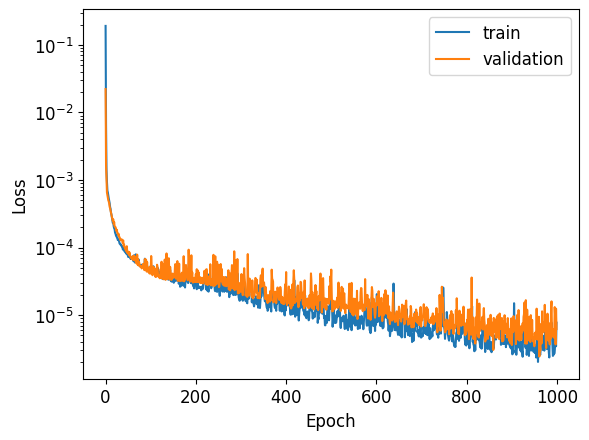

In [57]:
fig, ax = lstm.plot_loss()
ax.set_yscale('log')

In [58]:
y_pred = lstm.predict(x=lstm.testData[0])

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


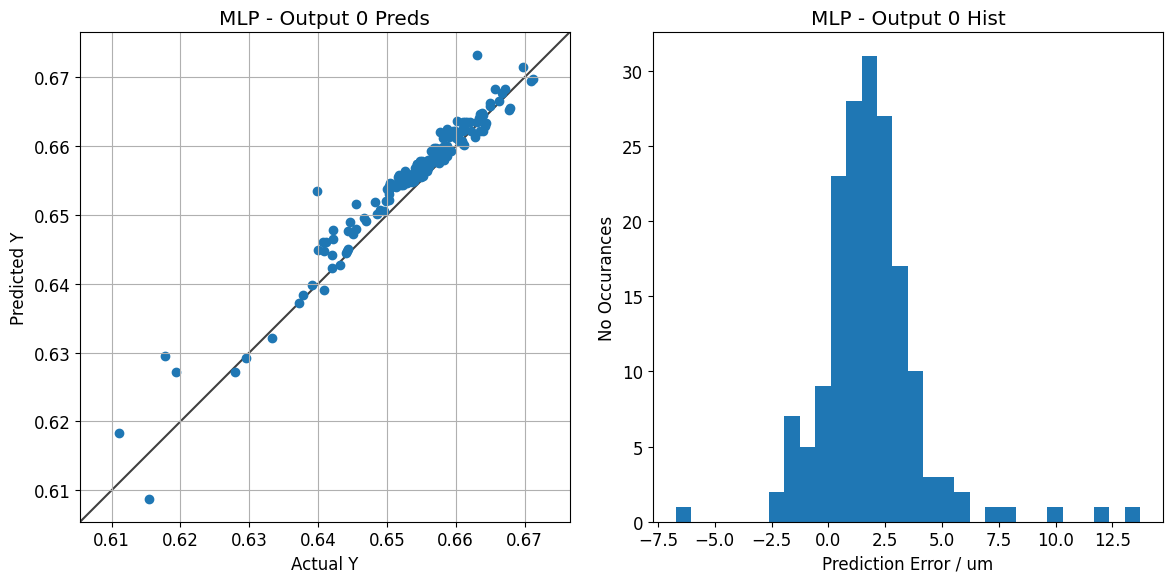

In [59]:
pred_plot(lstm.testData[1], y_pred, 'MLP')

In [60]:
sc = lstm.score(printout=True)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Data:
	mean_squared_error: 0.0000
	root_mean_squared_error: 0.0029
	mean_absolute_error: 0.0022
	r2_score: 0.9081
